<a href="https://colab.research.google.com/github/abatzel/Hands_on_ML/blob/master/07_ensemble_learning_and_random_forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 7. Ensemble learning and Random Forests

## Some definitions and intro:
A **model ensemble** is a collection of models that are combined in such a way to create a more powerful model!

A group (ensemble) of Decision Tree models, each trained on a different random subset of the training set, is a **Random Forest**.

\

An important rule for ensemble learning: the ensemble of models must be **sufficiently diverse** in order to produce a model with higher accuracy.  This diversity can be achieved by using a diversity of classifiers (models) or by randomly sampling from the training set for each model in order to diversify the training data that goes into each model (for example, in Random Forests.)

\

Common algorithms for ensemble learning are:

*   Bagging 
*   Boosting 
*   Stacking


##Bagging and Pasting

**Bagging** (*bootstrap - aggregating*) is sampling with replacement. **Pasting** is sampling *without* replacement. We use them to create random subsets of the training data in order to introduce some diversity into our models. 

![title](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0704.png)



![title](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0705.png)

<p style="text-align: center;"> Source: Hands on Machine Learning, Ch. 7</p>

The text doesn't explicitly say this, but deciding between using bagging versus pasting depends on the size of your training set. Since pasting is *without* replacement, you would want a larger dataset. However, bagging typically is the better choice.  While bagging ends up with a slightly higher bias than pasting, the added diversity from bootstrapping reduces the variance of the ensemble model. 

\

When you sample with replacement you will end up with an average of 63% of the training data in each model.  This means that the remaining 37% (called **out-of-bag** instances) can be used to validate/test the model without having to create a separate test set!

\

Greater diversity of classifiers = higher bias but lower variance

## Random Forests
A **Random Forest** is a ensemble of $T$ Decision Trees. Each decision tree casts a "vote" for a prediction and the ensemble predicts the majority vote of all of its trees.


![Title](https://miro.medium.com/max/789/1*VHDtVaDPNepRglIAv72BFg.jpeg)

<p style="text-align: center;"> Source: Towards Data Science</p>

### To train a Random Forest:

*  Make $T$ random samples of the training data that are of the same size of the training data but are sampled with replacement (bagging)
*   For each random sample of training data, *also* randomly subset the features for building the tree. 

Both of these steps introduce greater diversity to the ensemble, which **trades higher bias for lower variance**, and generally leads to a better model.






In [0]:
## Generate data
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

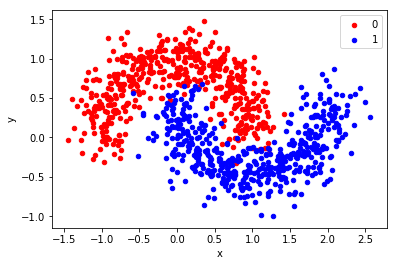

In [3]:
# scatter plot, dots colored by class value
from sklearn.datasets import make_moons
from matplotlib import pyplot
from pandas import DataFrame

df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

In [4]:
## Train a Random Forest with 500 trees with 16 max leaf nodes
## Note: THESE CAN BE TRAINED IN PARALLEL (use the cluster)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

## print accuracy 
accuracy_score(y_test, y_pred_rf)

0.976

97.6% (should be the same each time since we set a seed earlier) is pretty good wow!

### Benefits of Random Forests

*   As with ensemble methods, the collection of models makes a stronger model
*   There is less hyperparamter tuning needed (`max_leaf_nodes`, `n_estimators`, `min_samples_split`, ...)
*   It's efficient! (all of the trees can be trained in parallel)
* You can measure the relative importance of each feature; this is done in Scikit-Learn by seeing how much the nodes that use a given feature reduce impurity on average (a weighted average across all trees in the forest)


**Visualize one of the 500 decision trees**

In [5]:
# Extract single tree
estimator = rnd_clf.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = ["x", "y"],
                class_names = ["red", "blue"],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png', width = 1000, height = 1500)

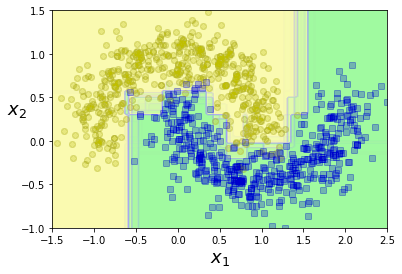

In [0]:
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

    
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

**Feature importance:** 


In our example, we only have two features ($x$ and $y$) so this isn't very interesting, but if you have a really wide dataset, this could help you with feature extraction!

In [10]:
for name, score in zip(df, rnd_clf.feature_importances_):
  print(name, score)


x 0.44213115774053896
y 0.557868842259461


Here, we can see that $y$ was a relatively more important feature. 

## Boosting (AdaBoost)

AdaBoost is similar in that it's also an ensemble method (that can also use Decision Trees), BUT differs from Random Forests in that:


*   It typically uses decision stumps instead of high depth trees (the default base estimator for the AdaBoostClassifier class is a *Decision Stump*, a DecisionTree)
*   Predictors are trained sequentially, each trying to correct it's predecessor (thus, they cannot be trained all in parallel as with a Random Forest)

![Title](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0707.png)



AdaBoost and Gradient Boost are both sequential learning techniques, but AdaBoost differs from Gradient Boost in that instead of tweaking a single model's parameters, AdaBoost adds models to the ensemble with each iteration to make it better. 

With Adaboost there are two sets of weights that we keep track of and update


*   Model (or, predictor) weights: $\alpha_j$
*   Instance weights (one for each "row" that is updated after training each model):  $w^{(i)}$



### The AdaBoost algorithm

0.   Each instance weight, $w^{(i)}$, is initially set to  $\frac{1}{m}$ where $m$ is the total number of rows in the dataset.
1.   Then, the first model/classifier, $\hat y_1$, is trained and it's weighted error rate, $r_1$ is computed on the training set: 
$$
 r_j = \frac{\sum_{i=1}^m w^{(i)} \mathbb{I}_{\hat y_j^{(i)} \neq y^{(i)}}}{\sum_{i=1}^m w^{(i)}}
$$
2.   Then, the first model's weight, $\alpha_1$, is computed:
$$
  \alpha_j = \eta \ln \left(\frac{1 - r_j}{r_j} \right)
$$ where $\eta$ is the learning rate (default of 1). The more accurate a model, the higher its weight will be.
3.   Recompute/update the instance weights, $w^{(i)}$ using:
$$
w^{(i)} \leftarrow 
\begin{array}{cc}
  \{ & 
    \begin{array}{cc}
      w^{(i)} & \text{if } \hat y_j^{(i)} = y^{(i)} \\
      e^{\alpha_j}w^{(i)} & \text{otherwise}
    \end{array}
\end{array}
$$
which boosts the weights of misclassified instances for the next iteration. Also, normalize the instance weights so that they sum to one so that they don't get too big or too small: 
$$
w^{(i)} \leftarrow \frac{w^{(i)}}{\sum_{j=1}^m w^{(j)}}
$$
5. Then, the next model, $\hat y_2$, is trained using the updated instance weights (step 1, repeated), and the process continues iteratively:
  1.   Train a new model on the updated instance weights
  2.   Calculate the model's weight based on its accuracy
  3.   Update and normalize the instance weights to boost the weights of misclassified instances
  ...*and repeat*





### AdaBoost Predictions


The predicted class is the one that receives the majority of weighted votes:
$$
\hat y = argmax_k \sum_{j=1}^N \mathbb{I}_{\hat y_j(x)=k} \alpha_j
$$ where N is the number of predictors (models).

In [11]:
## train adaboost classifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

In [0]:
## predict and print accuracy
y_pred_ada = ada_clf.predict(X_test)

## print accuracy 
accuracy_score(y_test, y_pred_ada)

0.972

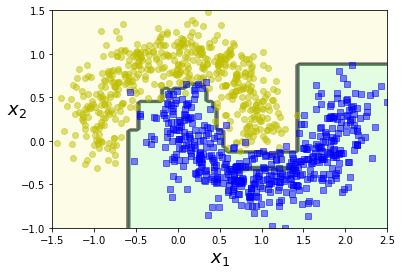

In [0]:
## visualize decision boundary
plot_decision_boundary(ada_clf, X, y)

## Gradient Boosting

**Gradient Boosting** also works by sequentially adding models; however, instead of changing the weights with each subsequent predictor, **Gradient Boosting** fits the new predictor on the *residual errors* of the previous one. 
\ 
To make a prediction, you add up the predictions of all of the trees.

![Title](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/assets/mls2_0709.png)